## Sprint 機械学習スクラッチ クラスタリング
### 2.K-meansスクラッチ


K-meansのクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

以下に雛形を用意してあります。このScratchKMeansクラスにコードを書き加えていってください。

《雛形》

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import seaborn as sns
import random
iris = load_iris()

from sklearn.preprocessing import StandardScaler

In [97]:
# class ScratchKMeans():
#     """
#     K-meansのスクラッチ実装
#     Parameters
#     ----------
#     n_clusters : int
#       クラスタ数
#     n_init : int
#       中心点の初期値を何回変えて計算するか
#     max_iter : int
#       1回の計算で最大何イテレーションするか
#     tol : float
#       イテレーションを終了する基準となる中心点と重心の許容誤差
#     verbose : bool
#       学習過程を出力する場合はTrue
#     """
#     def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
#         # ハイパーパラメータを属性として記録
#         self.n_clusters = n_clusters
#         self.n_init = n_init
#         self.max_iter = max_iter
#         self.tol = tol
#         self.verbose = verbose
#     def fit(self, X):
#         """
#         K-meansによるクラスタリングを計算
#         Parameters
#         ----------
#         X : 次の形のndarray, shape (n_samples, n_features)
#             訓練データの特徴量
#         """
#         if self.verbose:
#             #verboseをTrueにした際は学習過程を出力
#             print()
#         pass
#     def predict(self, X):
#         """
#         入力されたデータがどのクラスタに属するかを計算
#         """
#         pass
#         return

#### クラスタリングのための人工データセット
クラスタリングを実験するための人工データセットを作成するコードを用意しています。

このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 _（アンダースコア） で受け取っています。

《シンプルデータセット3》

In [98]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)
X.shape

(100, 2)

#### 学習
K-meansの学習に必要な要素を順番に作成していきます。

#### 【問題1】中心点の初期値を決める
入力されたデータから 
K
 個の中心点 
μ
1
 から 
μ
K
 の初期値を決めるコードを作成してください。
K
 は指定したクラスタ数です。

最もシンプルな初期値の決定方法は、データ点 
X
n
 の中からランダムに 
K
 個選ぶことです。今回はこれを実装してください。

K-meansの学習結果は中心点 
μ
 の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

In [99]:
k =np.random.randint(0,3,100)
k

array([1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 2, 0, 1, 2, 1, 2, 2,
       1, 1, 0, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 2,
       1, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 1, 1, 1, 2, 1,
       2, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 2, 2, 0, 2, 0, 1,
       2, 1, 1, 1, 0, 2, 0, 0, 1, 2, 1, 2])

In [100]:
label = np.unique(k)
label.shape[0]

3

In [101]:
np.zeros((3,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [102]:
uk =np.zeros([label.shape[0],X.shape[1]])
uk[0] = np.mean(X[k==0],axis=0)
uk[1]= np.mean(X[k==1],axis=0)
uk[2] = np.mean(X[k==2],axis=0)
uk

array([[ 0.0081348 ,  4.25246705],
       [ 0.22221626,  4.03671753],
       [-0.07175322,  3.89558046]])

In [103]:
for i in uk:
    print(i)

[0.0081348  4.25246705]
[0.22221626 4.03671753]
[-0.07175322  3.89558046]


#### 【問題2】SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。

K-meansはこのSSEを最小化する 
r
n
k
 と 
μ
k
 を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。
 
 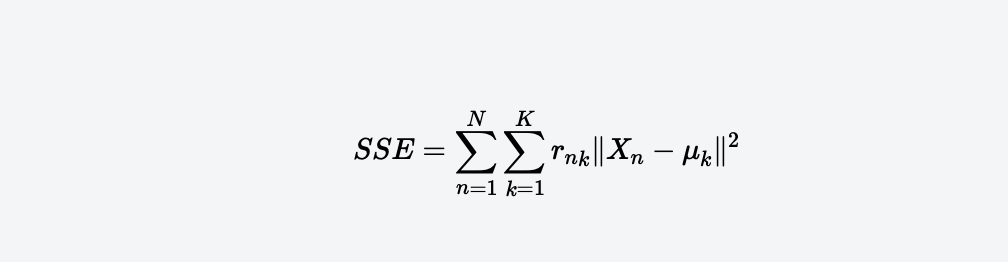
 
 
n
 : データ点のインデックス

k
 : クラスタのインデックス

X
n
 : 
n
番目のデータ点

μ
k
 : 
k
番目の中心点

r
n
k
 : データ点
X
n
がクラスタ
k
に所属していたら1、そうでなければ0

#### クラスタの割り当てと中心点の移動を繰り返す
-------------------------------------------
K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。

中心点 
μ
k
 を固定した上で 
S
S
E
 を最小化する クラスタの割り当て 
r
n
k
 を選ぶ。
クラスタの割り当て 
r
n
k
 を固定した上で 
S
S
E
 を最小化する 中心点 
μ
k
 を選ぶ。

最初の中心点 
μ
k
 は問題1で作成した初期値です。

順番に見ていきます。


In [104]:
w1=np.arange(1,5).reshape(2,2)
w2=np.arange(1,7).reshape(3,2)
z =  w1[:,:,np.newaxis] - w2.T[np.newaxis,:,:]
z,z.shape

(array([[[ 0, -2, -4],
         [ 0, -2, -4]],
 
        [[ 2,  0, -2],
         [ 2,  0, -2]]]),
 (2, 2, 3))

In [105]:
w1,w2.T

(array([[1, 2],
        [3, 4]]),
 array([[1, 3, 5],
        [2, 4, 6]]))

In [106]:
w1[:,:,np.newaxis] , w2.T[np.newaxis,:,:]

(array([[[1],
         [2]],
 
        [[3],
         [4]]]),
 array([[[1, 3, 5],
         [2, 4, 6]]]))

In [107]:
# sse = np.sum((X-center)**2,axis=1)[:,np.newaxis]
# sse.shape

In [108]:
norm_list = []
for i,uk_c in enumerate(uk):
    XX = (X[k==i] - uk_c)**2
    print(np.argmin(XX))

45
43
7


#### 【問題3】クラスタへの割り当て
全てのデータ点 
X
n
 を最も近い中心点 
μ
k
 に割り当てるコードを作成してください。

K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル 
p
,
q
 に対しては以下の数式で表現できます。
 
 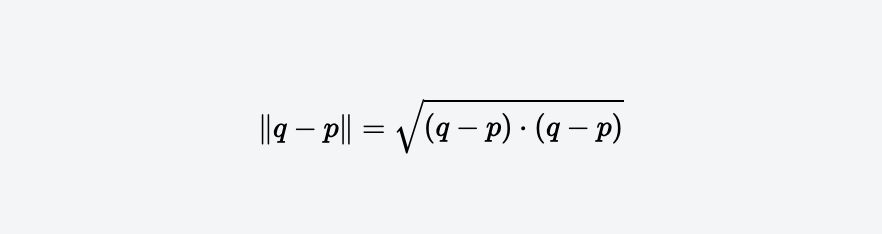
 
 NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。

[numpy.linalg.norm — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html)

中心点 
μ
k
 を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

In [109]:
from numpy import linalg as LA

In [110]:
norm = LA.norm(X[k==i] - uk_c,ord=2)
norm

15.741742710304255

In [111]:
norm_list = np.zeros((X.shape[0],uk.shape[0]))
for i,uk_c in enumerate(uk):
    norm = LA.norm(X - uk_c,ord=2,axis=1)
    norm_list[:,i] +=norm
norm_list.shape

(100, 3)

In [112]:
yy = np.argmin(norm_list,axis=1)
yy

array([1, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 0,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 2, 1, 2, 0, 2,
       2, 0, 2, 2, 1, 1, 0, 1, 2, 2, 2, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       2, 2, 1, 1, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 2, 0, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 2, 2, 0, 0, 2, 0, 0])

In [113]:
np.random.seed(10)
k =np.random.randint(0,3,100)
label = np.unique(k)
uk =np.zeros([label.shape[0],X.shape[1]])
norm_list = np.zeros((X.shape[0],uk.shape[0]))
rnk=np.zeros((X.shape[0],uk.shape[0]))
for j in range(label.shape[0]):
    uk[j] = np.mean(X[k==j],axis=0)

for i0 in range(X.shape[0]):
    for k0 in range(label.shape[0]):
        norm_list[i0,k0] = np.linalg.norm(X[i0,:] - uk[k0,:])**2
    k_n = np.argmin(norm_list[i0,:])
    rnk[i0,k_n]=1
rnk.shape

(100, 3)

#### 【問題4】中心点の移動
中心点 
μ
k
 を 
k
 番目のクラスタに割り当てられる全てのデータ点 
X
n
 の平均値（重心）に移動するコードを作成してください。

クラスタの割り当て 
r
n
k
 を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

In [114]:
# new_uk[0] = np.mean(X[rnk[:,0]==1],axis=0)
# new_uk[1]= np.mean(X[rnk[:,1]==1],axis=0)
# new_uk[2] = np.mean(X[rnk[:,2]==1],axis=0)
# new_uk

#### 【問題5】繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。

次のどれかの条件を満たしたらこれを止めます。

繰り返しが指定した回数に到達する。（雛形では引数max_iter）
中心点
μ
k
 と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）

In [115]:
np.random.seed(10)
k =np.random.randint(0,3,100)
label = np.unique(k)
uk =np.zeros([label.shape[0],X.shape[1]])
norm_list = np.zeros((X.shape[0],uk.shape[0]))
rnk=np.zeros((X.shape[0],uk.shape[0]))
max_iter = 10
for j in range(label.shape[0]):
    uk[j] = np.mean(X[k==j],axis=0)

for xx in range(max_iter):
    for i0 in range(X.shape[0]):
        for k0 in range(label.shape[0]):
            norm_list[i0,k0] = np.linalg.norm(X[i0,:] - uk[k0,:])**2
        k_n = np.argmin(norm_list[i0,:])
        rnk[i0,k_n]=1

    for x in range(label.shape[0]):
        uk[x] = np.mean(X[rnk[:,x]==1],axis=0)
uk

array([[ 0.58028941,  2.04299491],
       [-1.33836065,  6.37017011],
       [-0.27678616,  3.72096344]])

#### 【問題6】異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。

複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 
μ
k
 を保持しておきます。

In [116]:
# np.random.seed(71)
# k =np.random.randint(0,10,100)
# uk =np.zeros([label.shape[0],X.shape[1]])
# norm_list = np.zeros((X.shape[0],uk.shape[0]))
# rnk=np.zeros((X.shape[0],uk.shape[0]))
# max_iter = 100
# n_init = 10
# sse_list = []
# for m in range(n_init):
#     k =np.random.randint(0,10,100)
#     label = np.unique(k)
#     for j in range(label.shape[0]):
#         uk[j] = np.mean(X[k==j],axis=0)
#     for xx in range(max_iter):
#         for i0 in range(X.shape[0]):
#             for k0 in range(label.shape[0]):
#                 norm_list[i0,k0] = np.linalg.norm(X[i0,:] - uk[k0,:])**2
#             k_n = np.argmin(norm_list[i0,:])
#             rnk[i0,k_n]=1
#         for x in range(label.shape[0]):
#             uk[x] = np.mean(X[rnk[:,x]==1],axis=0)
#     sse = np.sum(norm_list)
#     sse_list.append(sse)

# min(sse_list)

#### 【問題7】推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。

- データ点 
X
n
 と学習で決まった中心点 
μ
k
 に対し、 
S
S
E
 を最小化する 
r
n
k
 を選ぶ。

具体的には次のことです。

- データ点 
X
n
 を最も近い 
μ
k
 に割り当てる。


In [216]:
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True)

In [222]:
class ScratchKMeans1():
    """
    K-meansのスクラッチ実装
    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters=3, n_init=500, max_iter=2, tol=0.5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        
        self.an = None
        self.bn = None
        self.k = None
        self.sse = None       
        self.X_center = None
        
    def _distance(self,X):

        i = X[:,:,np.newaxis]
        k = self.X_center.T[np.newaxis,:,:]
        self.h = i-k
        h2 = (self.h)**2
        uk = np.sum(h2,axis=1)
        return uk

    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        sse_list = []
        an_list = []
        bn_list = []
        uk_list = []
        center_list =[]
        
        #初期値を変えて実行
        for p in range(self.n_init):
            # 初期中心点格納
            self.X_center = np.zeros((self.n_clusters,X.shape[1]))
            
            #ランダムにクラスタを割り振る
            self.uk =  np.random.randint(0,self.n_clusters,(X.shape[0]))
            
            #クラスタのユニーク値
            self.label = np.unique(self.uk)
            
            #学習
            for ite in range(self.max_iter):
                
                #ラベルごとに計算
                for i in self.label:
                    
                    #重心の計算
                    self.X_center[i] = np.mean(X[self.uk==i,:],axis=0)
                    
                #重心から各点までの距離を計算
                self.sos = self._distance(X)
                
                #比較するためにセーブ
                save_uk = self.uk
                
                #最小のインデックスを取得（学習結果）
                self.uk = np.argmin(self.sos,axis=1)
                
                #更新した値と同じなら終わり
                if save_uk is self.uk:
                    break
                    
            #最小の値を代入
            sse_list.append(np.sum(np.amin(self.sos,axis=1)))
            
            #最小の距離
            an_list.append(np.min(self.sos,axis=1))
    
            #最大の距離
#             ind = np.ones((X.shape[0],self.n_clusters), dtype=bool)
#             ind[self.uk] = False
            bn_list.append(np.max(self.sos,axis=1))
            
            #ラベル
            uk_list.append(self.uk)
            
            #重心の格納
            center_list.append(self.X_center)
            
        #nan  を除いた最小値の取得
        sse_idx = np.nanargmin(sse_list)
        self.an = an_list[sse_idx]
        self.bn = bn_list[sse_idx]
        self.k = uk_list[sse_idx]
        self.sse = np.nanmin(sse_list)
        self.X_center = center_list[sse_idx]
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.sse)
        
        return 

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        
        sos = self._distance(X)
        
        label = np.argmin(sos,axis=1)
        

        return label

In [224]:
    kms1 = ScratchKMeans1(n_clusters=4,n_init=500, max_iter=10, verbose=False)
    kms1.fit(X)

In [225]:
y_pre = kms1.predict(X)
y_pre

array([1, 0, 3, 0, 3, 2, 0, 1, 2, 2, 0, 0, 3, 2, 0, 0, 1, 1, 2, 0, 2, 3,
       3, 3, 2, 2, 3, 1, 2, 3, 1, 2, 1, 2, 1, 2, 2, 3, 1, 3, 1, 0, 1, 1,
       1, 0, 2, 2, 3, 1, 1, 1, 2, 3, 1, 3, 3, 1, 2, 3, 3, 2, 1, 2, 0, 0,
       0, 0, 0, 3, 2, 1, 1, 0, 2, 1, 1, 2, 0, 1, 0, 3, 3, 0, 3, 0, 0, 3,
       0, 0, 3, 3, 3, 0, 2, 1, 0, 3, 2, 2])

In [140]:
xx = pd.DataFrame(X,columns=['X1','X2'])
yy = pd.DataFrame(y_pre,columns=['label'])
xy = pd.concat((xx,yy),1)
xy

X1        X2  label
0   -9.426966  0.781702      2
1   -9.902846  1.337395      2
2   -7.884901 -9.039770      1
3  -10.024568  1.341817      2
4    2.271969 -2.566220      3
..        ...       ...    ...
95  -4.965639  3.638257      0
96   2.311362 -2.587599      3
97  -7.547208 -8.236870      1
98  -7.765394 -8.551623      1
99  -5.754819  3.332814      0

[100 rows x 3 columns]

In [141]:
kms1.X_center

array([[-5.31567654,  3.0458648 ],
       [-7.5263956 , -8.63128089],
       [-9.93806746,  0.99720101],
       [ 2.69860039, -2.71894069]])

<AxesSubplot:xlabel='X1', ylabel='X2'>

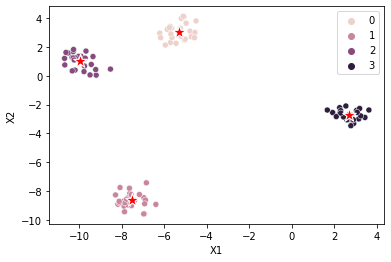

In [142]:
sns.scatterplot(x='X1',y='X2',data=xy,hue="label")
sns.scatterplot(kms1.X_center[:,0],kms1.X_center[:,1],marker='*',s=200,color='red')

In [143]:
# diver の感じでfor文で行った場合
class ScratchKMeans2():

    def __init__(self, n_clusters=3, n_init=70, max_iter=5, tol=0.5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.sse = None
                
    def fit(self, X):
#         np.random.seed(4)
#         k =np.random.randint(0,self.n_clusters,X.shape[0])
#         label = np.unique(k)
#         uk =np.zeros([label.shape[0],X.shape[1]])
#         norm_list = np.zeros((X.shape[0],uk.shape[0]))
#         norm=np.zeros((X.shape[0],uk.shape[0]))
        sse_list = []
        for _ in range(self.n_init):
            k =np.random.randint(0,self.n_clusters,X.shape[0])
            label = np.unique(k)
            uk =np.zeros([label.shape[0],X.shape[1]])
            norm_list = np.zeros((X.shape[0],uk.shape[0]))
            norm=np.zeros((X.shape[0],uk.shape[0]))
            label = np.unique(k)
            for j in range(label.shape[0]):
                uk[j] = np.mean(X[k==j],axis=0)
            for xx in range(self.max_iter):
                rnk=np.zeros((X.shape[0],uk.shape[0]))
                for i0 in range(X.shape[0]):
                    for k0 in range(label.shape[0]):
                        norm_list[i0,k0] = np.linalg.norm(X[i0,:] - uk[k0,:])**2

                    k_n = np.argmin(norm_list[i0,:])
                    norm[i0,k_n] = min(norm_list[i0,:])
                    rnk[i0,k_n]=1
                    #print(norm)
                #print(norm_list.shape)
                for x in range(label.shape[0]):
                    uk[x] = np.mean(X[rnk[:,x]==1],axis=0)
            sse = np.sum(norm)
            #print(sse)
            sse_list.append(sse)
        self.sse = min(sse_list)
            #print(self.sse)
            #print(rnk)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.uk)

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        sos = self.sse(X,self.X_center)
        
        label = np.argmin(sos,axis=1)
        

        return label

In [156]:
k = 7
kms_list = np.zeros((k,1))
i_list = []
for i in range(k):
    kms = ScratchKMeans1(n_clusters=i+1,n_init=1000, max_iter=5)
    kms.fit(X)
    kms_list[i] += kms.sse
    i_list.append(i+1)

In [157]:
kms_list

array([[4272.56753724],
       [2112.23188345],
       [ 368.4030115 ],
       [  48.85899704],
       [  41.3512679 ],
       [  38.16057238],
       [  31.67189354]])

In [158]:
i_list

[1, 2, 3, 4, 5, 6, 7]

#### 【問題8】エルボー法の実装
K-meansにおいて中心点の個数 
k
 は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数 
k
 を検討するためのコードを作成してください。

SSEを縦軸、クラスタ数 
k
 を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

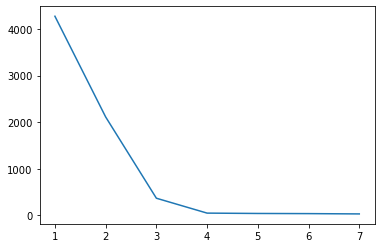

In [159]:
plt.plot(i_list,kms_list[:,0])

#### 【問題9】（アドバンス課題）シルエット図
k
 を決める助けになるものとしてシルエット図もあります。シルエット図を表示するコードを作成してください。

Matplotlibを使い図を表示するコードは用意しました。以下を与えてください。

silhouette_vals : shape(n_samples,)のndarray、各データ点のシルエット係数

silhouette_avg : float、シルエット係数の平均値

y_km : shape(n_samples,)のndarray、各データ点のクラスタラベル名

cluster_labels : list、クラスタのラベル名のリスト

n_clusters : int、クラスタ数

n
 番目のデータ点に対するシルエット係数 
s
n
 は以下の数式でを求められます。この数式を実装し、シルエット図を確認してください。
 
 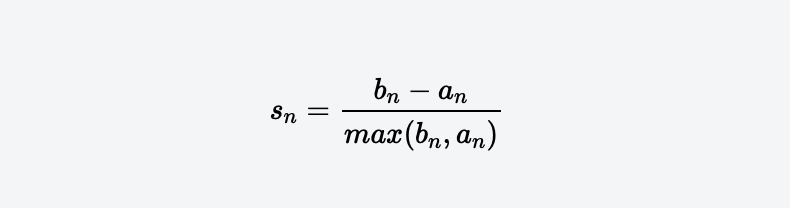
 
 a
n
 : 凝集度。同じクラスタ内の他のデータ点との距離の平均値。

b
n
 : 乖離度。最も近い他のクラスタ内の全てのデータ点との距離の平均値。

乖離度 
b
 が大きく、凝集度 
a
 が小さい時が理想的であり、シルエット係数 
s
 は1に近くなります。

《シルエット図を表示するためのコード》

In [160]:
    kms1 = ScratchKMeans1(n_clusters=4,n_init=1000, max_iter=10, verbose=False)
    kms1.fit(X)

In [213]:
n_clusters= kms1.n_clusters
cluster_labels= np.unique(kms1.k)
y_km= kms1.k
an = kms1.an[:,np.newaxis]
bn = kms1.bn[:,np.newaxis]
cn = np.concatenate((an,bn),axis=1)
silhouette_vals = (bn - an)/(np.max((cn),axis=1))[:,np.newaxis]

silhouette_avg=np.mean(silhouette_vals)

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.7403328901140267
For n_clusters = 3 The average silhouette_score is : 0.8524062613438004
For n_clusters = 4 The average silhouette_score is : 0.8612383686097822
For n_clusters = 5 The average silhouette_score is : 0.7092825549111827
For n_clusters = 6 The average silhouette_score is : 0.5593497890378833


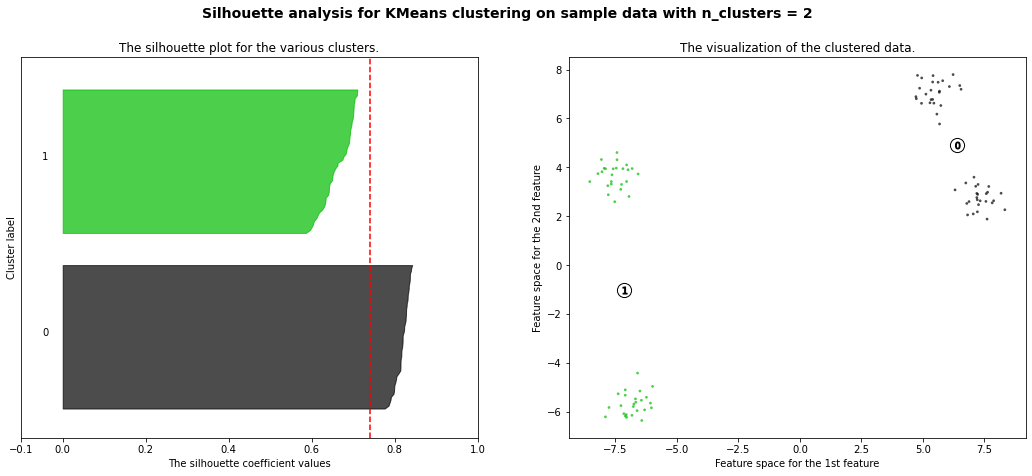

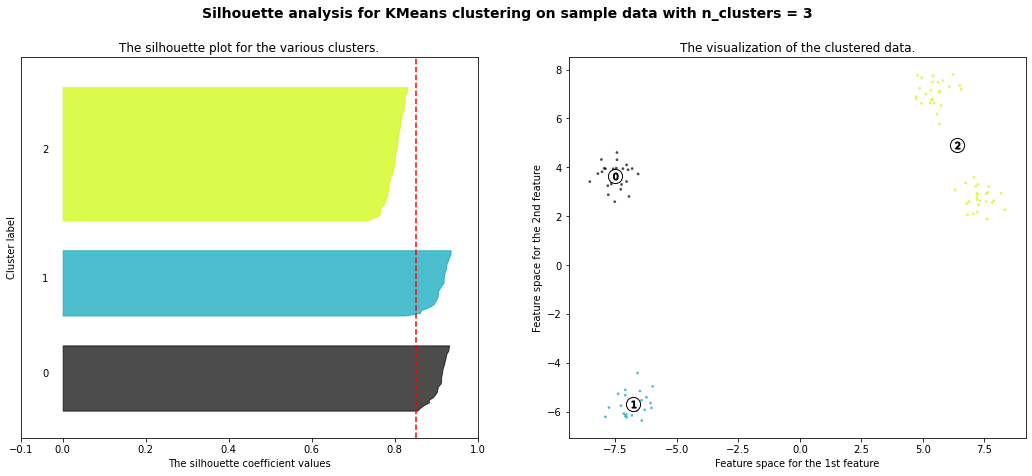

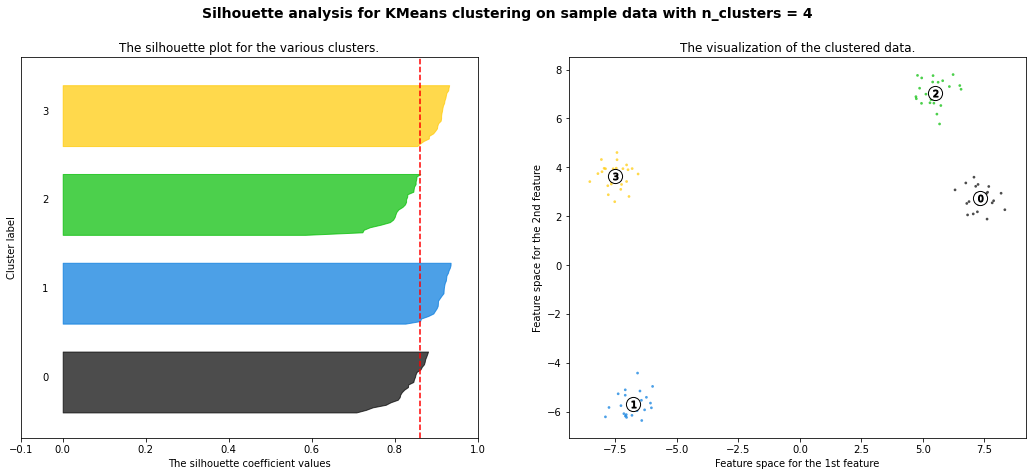

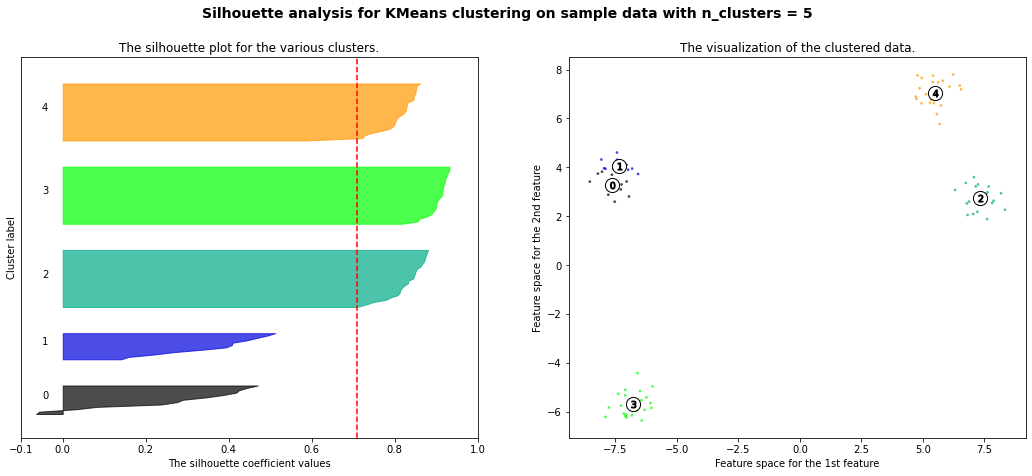

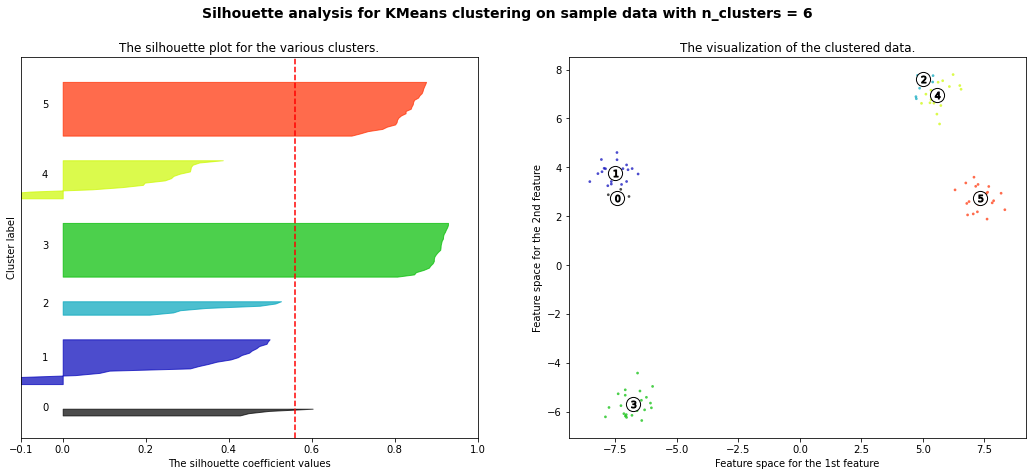

In [226]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = ScratchKMeans1(n_clusters=n_clusters)
    clusterer.fit(X)
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.X_center
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### 3.クラスタ分析


#### 卸売業者のデータ分析
クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。

[UCI Machine Learning Repository: Wholesale customers Data Set](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)

Data Folderの中からWholesale customers data.csvをダウンロードしてください。これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。

#### 次元削減
金額に関する特徴量は6個ありますが、可視化するために次元削減を行います。これに関してはscikit-learnによるPCAのサンプルコードを用意したので利用してください。

《PCAのサンプルコード》


In [249]:
data = pd.read_csv("Wholesale customers data.csv")
data = data.iloc[:,2:]
data

Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0    12669   9656     7561     214              2674        1338
1     7057   9810     9568    1762              3293        1776
2     6353   8808     7684    2405              3516        7844
3    13265   1196     4221    6404               507        1788
4    22615   5410     7198    3915              1777        5185
..     ...    ...      ...     ...               ...         ...
435  29703  12051    16027   13135               182        2204
436  39228   1431      764    4510                93        2346
437  14531  15488    30243     437             14841        1867
438  10290   1981     2232    1038               168        2125
439   2787   1698     2510      65               477          52

[440 rows x 6 columns]

In [250]:
data = data.apply(np.log)
data

Fresh      Milk    Grocery    Frozen  Detergents_Paper  Delicassen
0     9.446913  9.175335   8.930759  5.365976          7.891331    7.198931
1     8.861775  9.191158   9.166179  7.474205          8.099554    7.482119
2     8.756682  9.083416   8.946896  7.785305          8.165079    8.967504
3     9.492884  7.086738   8.347827  8.764678          6.228511    7.488853
4    10.026369  8.596004   8.881558  8.272571          7.482682    8.553525
..         ...       ...        ...       ...               ...         ...
435  10.299003  9.396903   9.682030  9.483036          5.204007    7.698029
436  10.577146  7.266129   6.638568  8.414052          4.532599    7.760467
437   9.584040  9.647821  10.317020  6.079933          9.605149    7.532088
438   9.238928  7.591357   7.710653  6.945051          5.123964    7.661527
439   7.932721  7.437206   7.828038  4.174387          6.167516    3.951244

[440 rows x 6 columns]

In [251]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)

《PCAの分散説明率を表示するコードサンプル》

[0.44237417 0.71894523 0.83511865 0.93129585 0.97705265 1.        ]


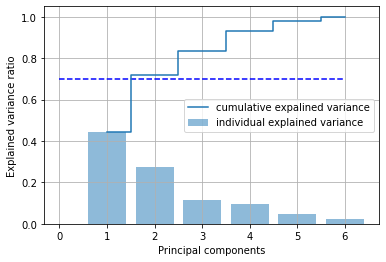

In [252]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

In [253]:
X = data_pca
X.shape

(440, 2)

#### 【問題10】クラスタ数kの選択
最適だと思われるクラスタ数 
k
 を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

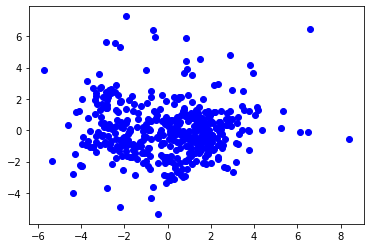

In [254]:
plt.plot(data_pca[:,0],data_pca[:,1],'bo')

In [255]:

k = 10
kms_list = np.zeros((k,1))
i_list = []
for i in range(k):
    kms = ScratchKMeans1(n_clusters=i+1,n_init=1000, max_iter=10)
    kms.fit(X)
    kms_list[i] += kms.sse
    i_list.append(i+1)

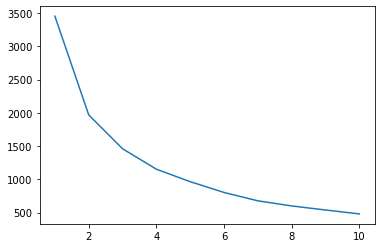

In [257]:
plt.plot(i_list,kms_list[:,0])

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.4162391388918358
For n_clusters = 3 The average silhouette_score is : 0.3911252117178196
For n_clusters = 4 The average silhouette_score is : 0.323010960710503
For n_clusters = 5 The average silhouette_score is : 0.3300619075176958
For n_clusters = 6 The average silhouette_score is : 0.33569155957503316


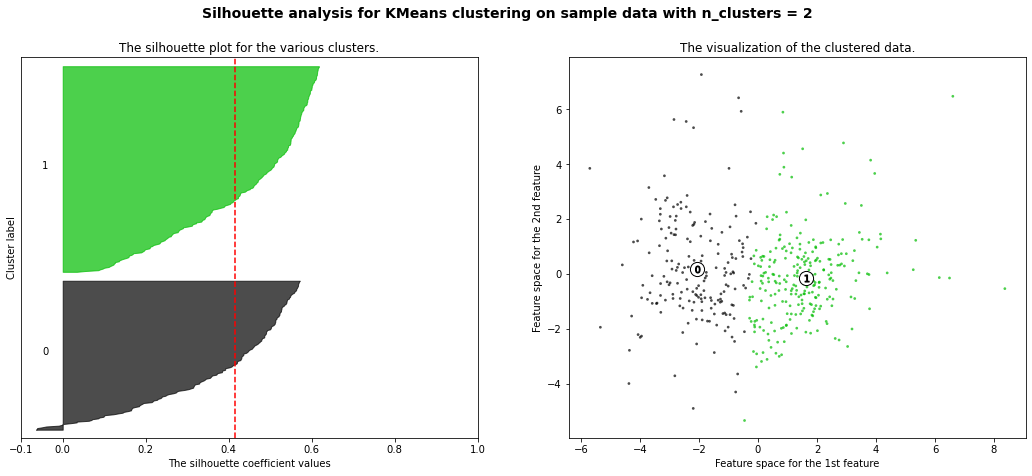

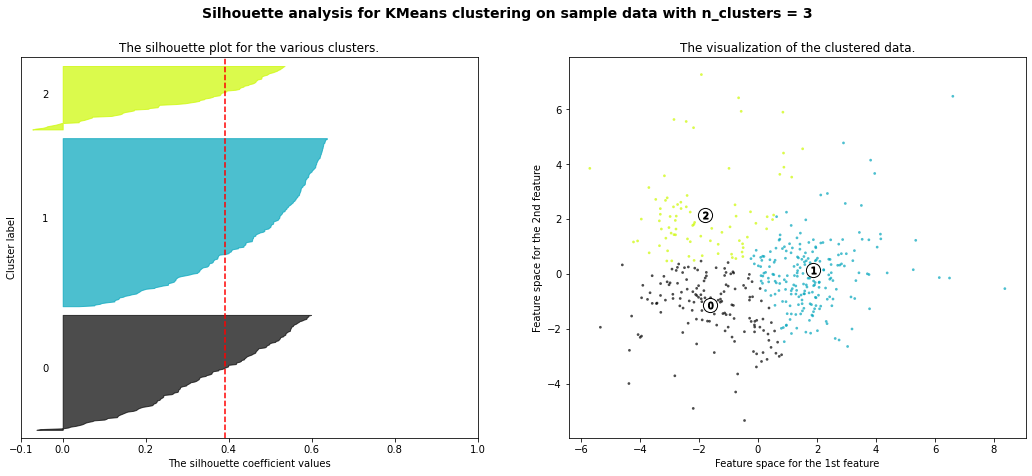

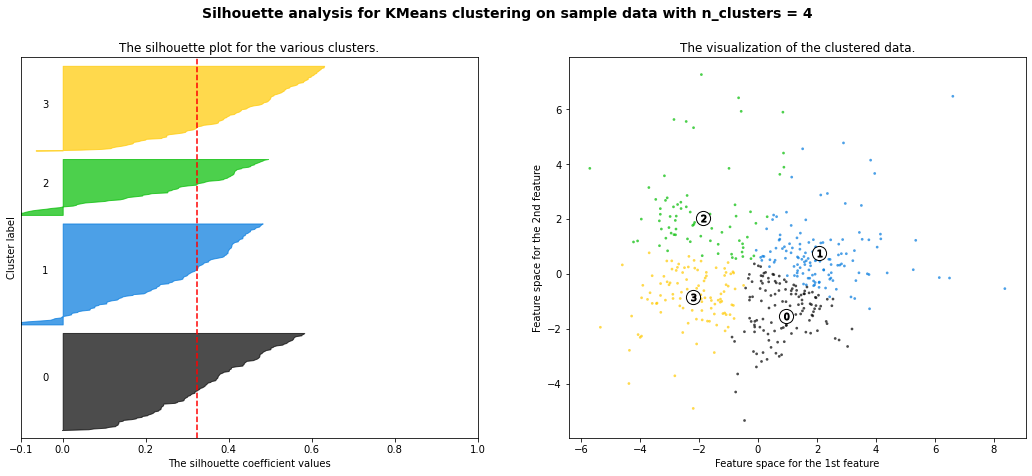

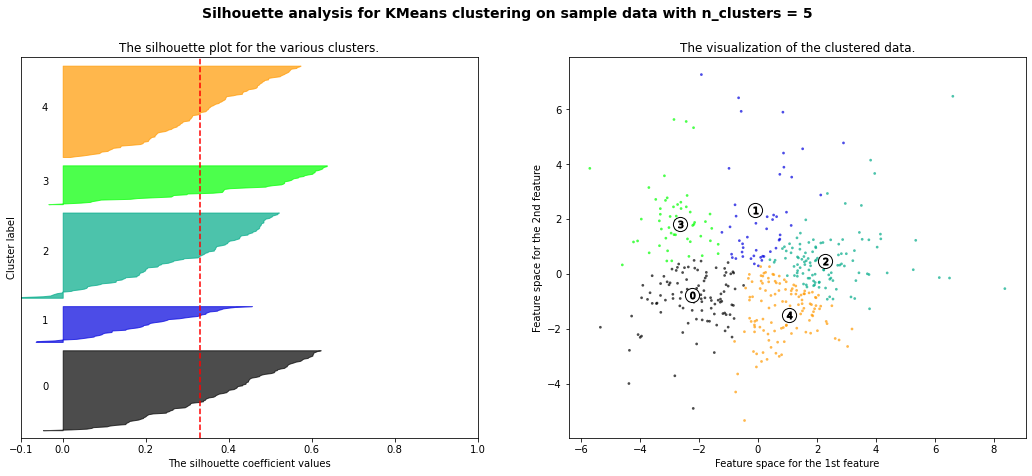

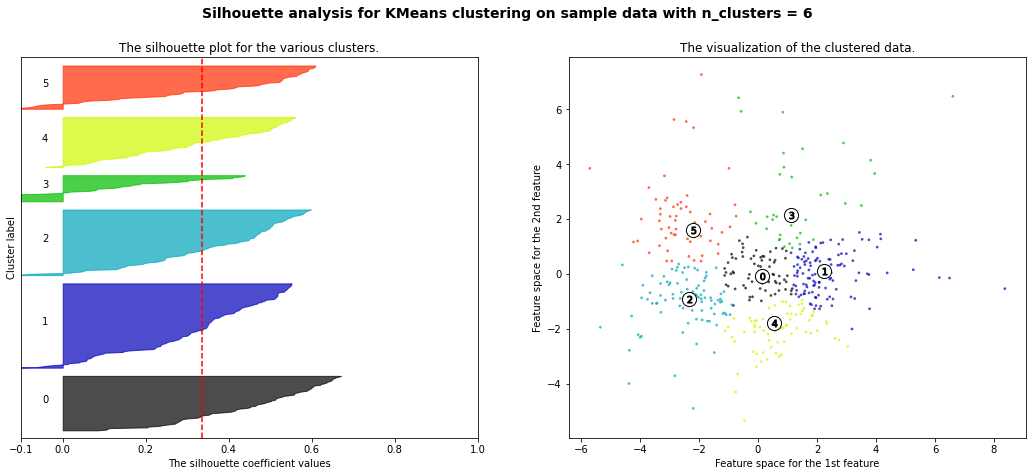

In [258]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = ScratchKMeans1(n_clusters=n_clusters)
    clusterer.fit(X)
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.X_center
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

主成分分析で二つの特徴量に分けたが、k-meansのエルボー法を使用するとクラスタ数3が良いという結果となった。  
またシルエット図法を使用するとクラスタ数２が妥当という結果となった。


#### 【問題11】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

In [289]:
data = pd.read_csv("Wholesale customers data.csv")

data.head()

Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

In [287]:
data.groupby(['Channel', 'Region']).mean()

Fresh          Milk       Grocery       Frozen  \
Channel Region                                                          
1       1       12902.254237   3870.203390   4026.135593  3127.322034   
        2       11650.535714   2304.250000   4395.500000  5745.035714   
        3       13878.052133   3486.981043   3886.734597  3656.900474   
2       1        5200.000000  10784.000000  18471.944444  2584.111111   
        2        7289.789474   9190.789474  16326.315789  1540.578947   
        3        9831.504762  10981.009524  15953.809524  1513.200000   

                Detergents_Paper   Delicassen  
Channel Region                                 
1       1             950.525424  1197.152542  
        2             482.714286  1105.892857  
        3             786.682464  1518.284360  
2       1            8225.277778  1871.944444  
        2            8410.263158  1239.000000  
        3            6899.238095  1826.209524

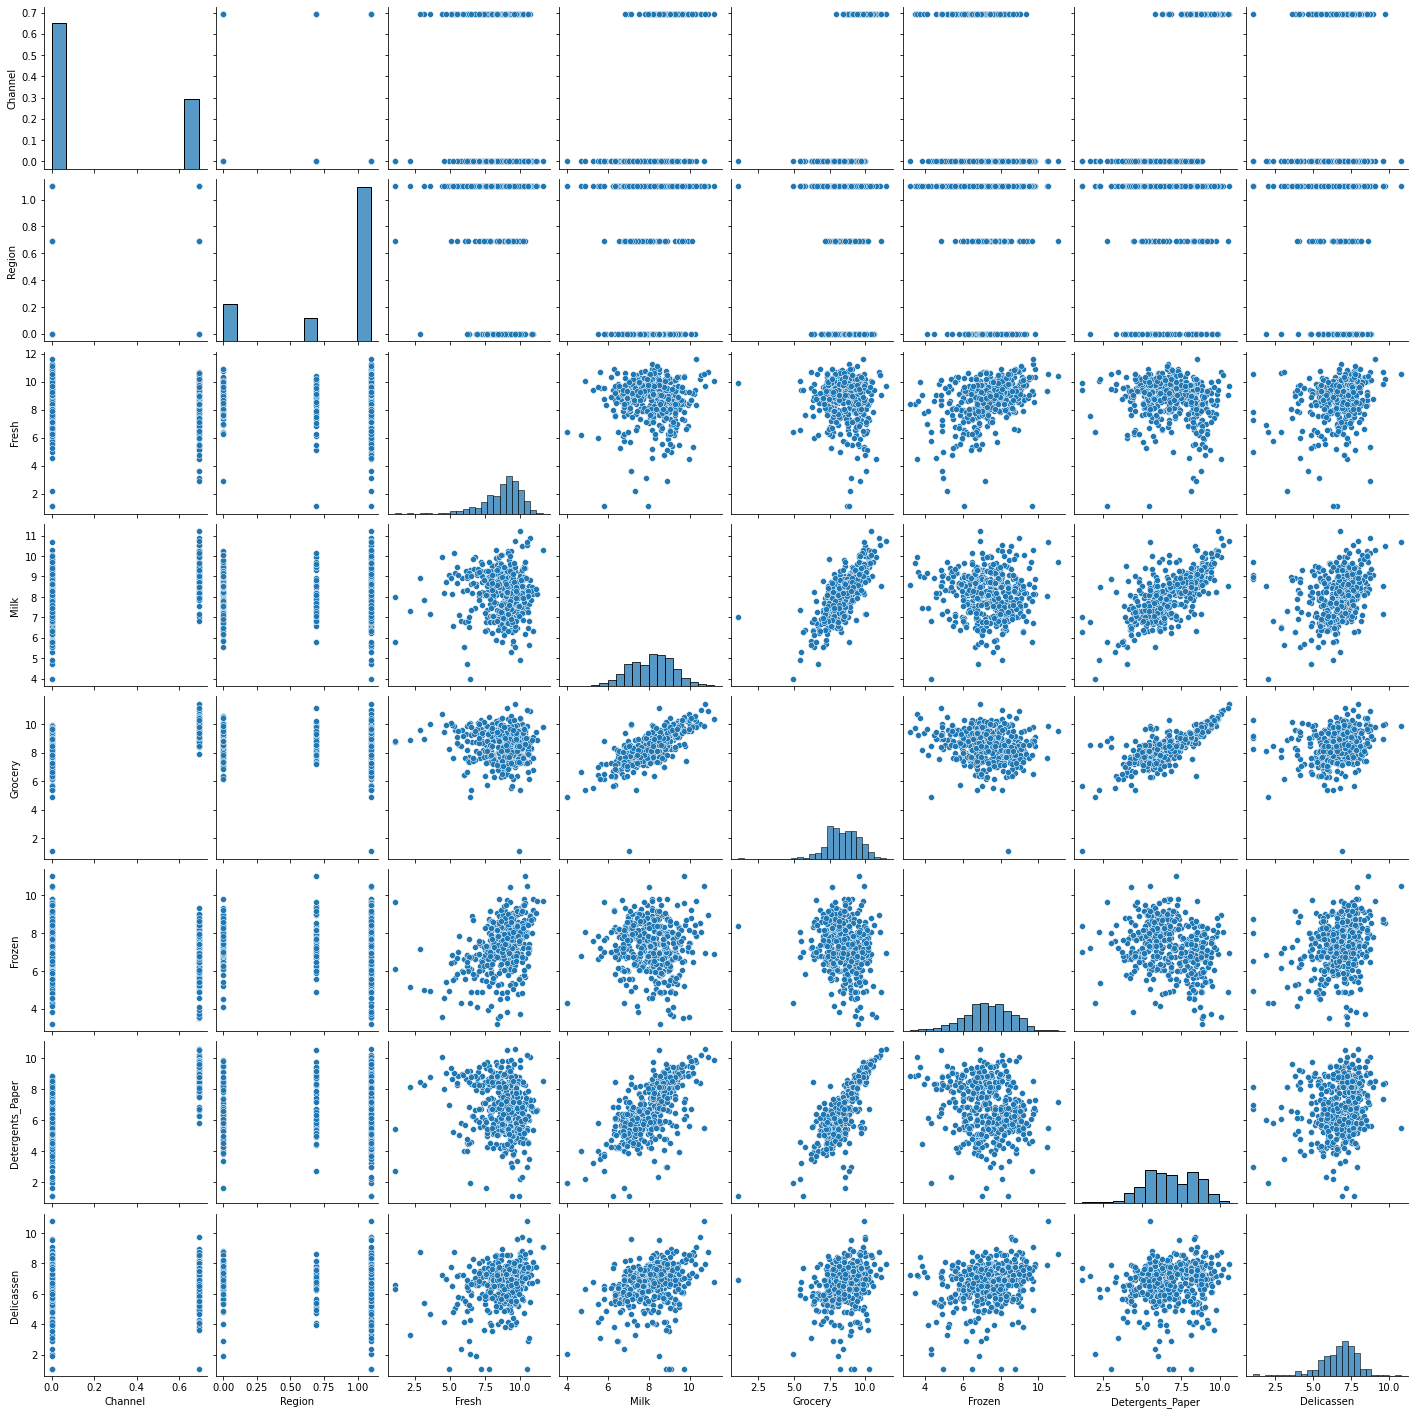

In [262]:
sns.pairplot(data);

チャネルとリージョンは離散値となっており完全に分かれている。

In [293]:
    kms1 = ScratchKMeans1(n_clusters=2,n_init=1000, max_iter=10, verbose=False)
    kms1.fit(data_pca)

In [290]:
data = data.apply(np.log)
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)

In [296]:
p1 = pd.DataFrame(data_pca,columns=['X1','X2'])
p2 = pd.DataFrame(kms1.k,columns=['label'])
pp = pd.concat((p1,p2),1)
pp

X1        X2  label
0   -1.793834 -0.068975      1
1   -1.841464 -0.868573      1
2   -1.932801 -1.675631      1
3    1.145193 -1.456108      0
4   -0.842677 -2.458586      1
..        ...       ...    ...
435  0.628464 -2.890680      0
436  3.190515 -2.003516      0
437 -3.778200 -0.927855      1
438  1.672175 -0.473441      0
439  0.752748  3.636286      0

[440 rows x 3 columns]

<AxesSubplot:xlabel='X1', ylabel='X2'>

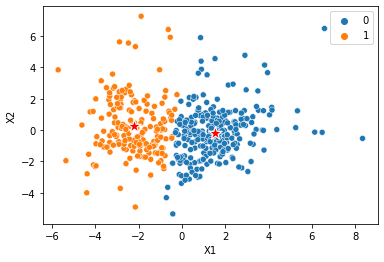

In [298]:
sns.scatterplot(x='X1',y='X2',data=pp,hue='label')
sns.scatterplot(kms1.X_center[:,0],kms1.X_center[:,1],marker='*',s=200,color='red')

k-meansを利用して分類分けされたものをクラスタと呼ぶ

#### 【問題12】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。

《ヒント》

前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。

条件ごとにデータを見る際にはPandasのgroupbyが便利です。

[pandas.DataFrame.groupby — pandas 0.23.4 documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html)

In [264]:
data = pd.read_csv("Wholesale customers data.csv")
data.describe()

Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  
count    440.000000        440.000000    440.000000  
mean    3071.931818       2881.493182   1524.870455  
std     4854.673333       4767.854448   2820.105937  
min       25.000000          3.000000      3.000000  
25%      742.250000        256.750000    408.250000  
50%     1526.000000        816.500000    965.500000  
75%     3554.250000       3922.000000   1820.250000  
max    60869.000000      40827.000000  47943.000000

<AxesSubplot:>

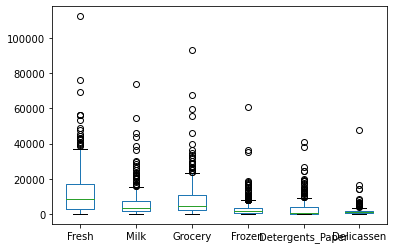

In [265]:
data.iloc[:,2:9].plot.box()

<AxesSubplot:ylabel='Frequency'>

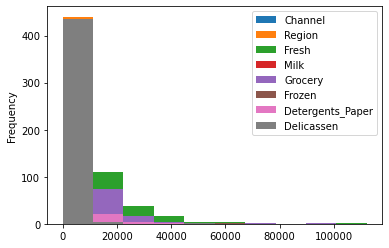

In [266]:
data.plot.hist()

In [267]:
X = data.values

k = 10
kms_list = np.zeros((k,1))
i_list = []
for i in range(k):
    kms = ScratchKMeans1(n_clusters=i+1,n_init=1000, max_iter=10)
    kms.fit(X)
    kms_list[i] += kms.sse
    i_list.append(i+1)

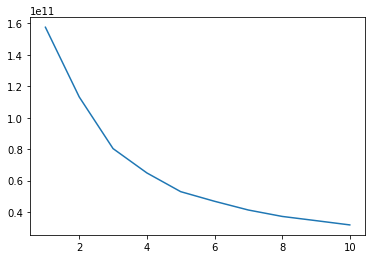

In [268]:
plt.plot(i_list,kms_list[:,0])

６つの特徴量を使うと５つのクラスに分類できることがわかる。

In [269]:
data2 = data.iloc[:,4:]
data2

Grocery  Frozen  Detergents_Paper  Delicassen
0       7561     214              2674        1338
1       9568    1762              3293        1776
2       7684    2405              3516        7844
3       4221    6404               507        1788
4       7198    3915              1777        5185
..       ...     ...               ...         ...
435    16027   13135               182        2204
436      764    4510                93        2346
437    30243     437             14841        1867
438     2232    1038               168        2125
439     2510      65               477          52

[440 rows x 4 columns]

In [270]:
X = data2.values

k = 10
kms_list = np.zeros((k,1))
i_list = []
for i in range(k):
    kms = ScratchKMeans1(n_clusters=i+1,n_init=1000, max_iter=10)
    kms.fit(X)
    kms_list[i] += kms.sse
    i_list.append(i+1)

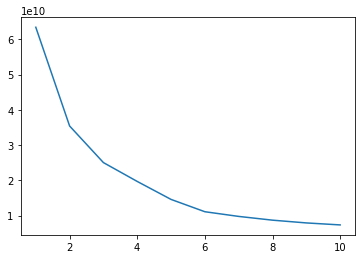

In [271]:
plt.plot(i_list,kms_list[:,0])

後半４つの特徴量は２、３の特徴量に分けれると考えられる。

地域の差も多少あるが、経路の違いで大きく買われた額の平均値が違う。
それぞれの値にばらつきが激しいことがわかった。

### 4.他の非階層クラスタリング手法


#### 【問題13】（アドバンス課題）他の手法の調査
今回扱ったK-means以外に非階層クラスタリングで有名な手法としては DBSCAN 、
PCA以外に次元削減手法で有名な手法としては t-SNE や LLE があります。

DBSCANのメリット・デメリット
t-SNE、LLEのメリット・デメリット

について記述してください。


#### DBSCAN 
メリット：クラスタ数を設定する必要がない
                    ノイズの除去ができる  
                    クラスターが再帰的に決定されていくため、外れ値（outlier）の影響を受けにくい  
デメリット：計算にもそれなりの時間がかかるということ。リアルタイム性が求められるような場合には不向き
                    データが密集していると、適切なパラメータを決めるのが難しい  
#### tーSNE
メリット：   高次元の局所的な構造を非常によく捉える  
                    大局的な構造も可能な限り捉える  
デメリット：Perplexity(内部のパラメータ)を変えると全くことなるクラスターが出現してしまう  
#### LLE
メリット：距離の近いサンプルは見える化・可視化したあとも(２次元平面上でも)近くなるようにしよう

#### 【問題14】（アドバンス課題）t-SNEとDBSCANの利用
Wholesale customersのデータに対して、PCAではなく、 t-SNE を用いて次元削減をしてください。さらにK-meansではなく、 DBSCAN を用いてクラスタリングしてください。

そのクラスタリング結果をPCA+kmeansの場合の結果と比較してみましょう。実装にはscikit-learnを用いてください。


[sklearn.manifold.TSNE — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[sklearn.cluster.DBSCAN — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

《パラメーターチューニング》

これらはK-meansやPCAに比べパラメーターチューニングが難しい手法です。scikit-learnのドキュメントと共に論文も参考にしながらパラメータの意味を確認することも大切になります。

[t-SNEの論文](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

[DBSCANの論文](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

In [281]:
data = pd.read_csv("Wholesale customers data.csv")
data = data.iloc[:,2:]
data.head()

Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0  12669  9656     7561     214              2674        1338
1   7057  9810     9568    1762              3293        1776
2   6353  8808     7684    2405              3516        7844
3  13265  1196     4221    6404               507        1788
4  22615  5410     7198    3915              1777        5185

In [279]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(440, 2)

In [274]:
from sklearn.cluster import DBSCAN

In [275]:
clustering = DBSCAN(eps=3, min_samples=2).fit(X_embedded )
y = clustering.labels_

In [295]:
a = pd.DataFrame(X_embedded,columns=['x','y'])
b = pd.DataFrame(y,columns=['label'])
c= pd.concat((a,b),1)
c.head()

x         y  label
0  -9.270056 -2.912524      0
1 -11.842339  3.680506      0
2  -2.849518  2.526807      0
3  10.894614  4.208827      0
4  -2.117341  1.827663      0

<AxesSubplot:xlabel='x', ylabel='y'>

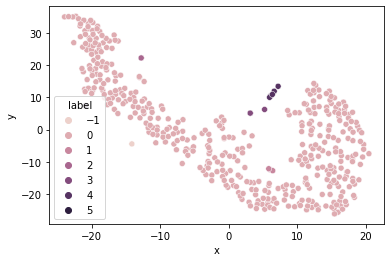

In [277]:
sns.scatterplot(x='x',y='y',data=c,hue="label")

<AxesSubplot:xlabel='X1', ylabel='X2'>

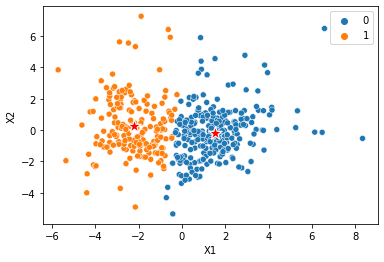

In [297]:
sns.scatterplot(x='X1',y='X2',data=pp,hue='label')
sns.scatterplot(kms1.X_center[:,0],kms1.X_center[:,1],marker='*',s=200,color='red')